# COMP309 Capstone Project

#### Marrick Lip, 2019

In [ ]:
from sklearn.neural_network import MLPClassifier

In [201]:
labels = ['tomato', 'cherry', 'strawberry']
image_paths_by_label = {
    label: glob.glob(f'data/Train_data/{label}/*') for label in labels
}

image_size = (32, 32)
n_images = sum(len(image_paths_by_label[label]) for label in labels) - 1 #stupid grayscale image

X = np.ndarray((n_images, 3 * np.product(image_size)))
y = np.ndarray((n_images), dtype=object)

i = 0
for label, image_paths in image_paths_by_label.items():
    for image_path in tqdm(image_paths, label):
        image = imageio.imread(image_path)
        
        # skip the grayscale image
        if image.shape[-1] != 3: continue
        
        resized = skimage.transform.resize(image, image_size)

        X[i, :] = resized.ravel()
        y[i] = label
        
        i += 1

KeyboardInterrupt: 

In [70]:
train_pct = 0.7
is_train = np.random.random(n_images) < train_pct

X_train, X_test = X[is_train], X[~is_train]
y_train, y_test = y[is_train], y[~is_train]

In [80]:
start_time = time.time()

model = MLPClassifier(hidden_layer_sizes=(100,100, 100), max_iter=500)
model.fit(X_train, y_train)

print(f'Fitted model in {time.time()-start_time:0.2f}s.')
print(f'Train accuracy: {model.score(X_train, y_train):0.3f}')
print(f'Test accuracy: {model.score(X_test, y_test):0.3f}')


Fitted model in 15.34s.
Train accuracy: 0.989
Test accuracy: 0.485


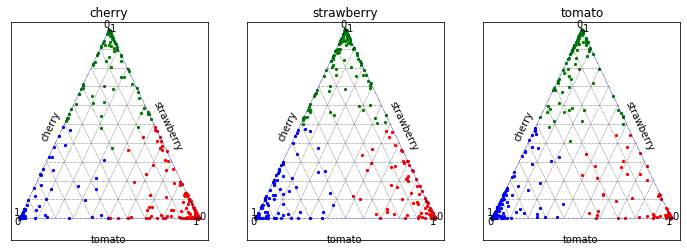

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

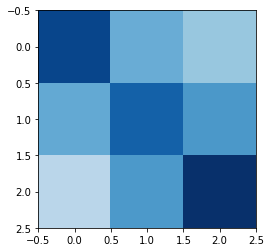

In [202]:
plot_ternary(
    model.classes_,
    y_test,
    model.predict_proba(X_test),
)

plt.show()

plot_confusion_matrix(
    labels,
    sklearn.metrics.confusion_matrix(
        y_test,
        model.predict(X_test)
    )
)

## [0] Setup

### 0.1 Get the dependencies

In [1]:
#%%capture
# ^ hide the output

!conda update --all --yes
!conda install cudnn --yes

!pip install --upgrade pip
!pip install tensorflow-gpu
!pip install imutils
!pip install tqdm
!pip install pyyaml h5py
!pip install tensorflow-hub
pip install python-ternary

Solving environment: / ^C
failed
Solving environment: \ ^C
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/pip", line 7, in <module>
    from pip._internal.main import main
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pip/_internal/main.py", line 13, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pip/_internal/cli/autocompletion.py", line 11, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pip/_internal/cli/main_parser.py", line 7, in <module>
    from pip._internal.cli import cmdoptions
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pip/_internal/cli/cmdoptions.py", line 28, in <module>
    from pip._internal.models.target_python import TargetPython
  File "/

### 0.2 Import the dependencies

In [187]:
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import glob
import imageio
import random
import math
import shutil
import requests
import skimage
import uuid
import time
import ternary

import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub
from tqdm.notebook import tqdm
from collections import defaultdict
import sklearn

# create a directory if it doesn't already exist
make_dir = lambda path: os.path.exists(path) or os.makedirs(path)

### 0.3 Constants

In [15]:
IMG_HEIGHT = 224 #300 
IMG_WIDTH = 224 # 300
train_pct = 0.7
batch_size = 24

## [1] Get the Data

### 1.1 Create directories for the test and train data

In [16]:
!rm -rf data
make_dir('data')
make_dir('data/train')
make_dir('data/test')

### 1.1 Get the provided dataset

#### 1.1.1 Download and unzip the images

In [17]:
if not os.path.exists('train.zip'):
    !curl https://ecs.victoria.ac.nz/foswiki/pub/Courses/COMP309_2019T2/Assignments/Train_data_2019.zip -o train.zip
!unzip -oq train.zip -d data

#### 1.1.2 Split the images using 309 as a seed

In [6]:
random.seed(309)
for label_dir in glob.glob('data/Train_data/*'):
    label = label_dir.split('/')[-1]
    make_dir(f'data/train/{label}')
    make_dir(f'data/test/{label}')
    
    images = glob.glob(f'{label_dir}/*')
    random.shuffle(images)
    
    split_index = math.floor(len(images) * train_pct)
    for i, image in tqdm(enumerate(images), label):
        train_or_test = 'train' if i < split_index else 'test'
        new_path = image.replace('Train_data', train_or_test)
        shutil.move(image, new_path)

# clean-up the unzipped directory (will be empty)
!rm -rf data/Train_data
!rm -rf data/__MACOSX

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


### 1.2 Get images from ImageNet

#### 1.2.1 Fetch the ImageNet urls

In [7]:
!ls imagenet_urls/

ls: cannot access imagenet_urls/: No such file or directory


In [8]:
imagenet_urls_path = 'imagenet_urls/fall11_urls.txt'
if not os.path.exists(imagenet_urls_path):
    !rm -rf imagenet_urls 
    !mkdir imagenet_urls

    # n.b. the main site is down: use a mirror
    !wget https://v.im.cyut.edu.tw/ftp/18/imagenet_fall11_urls.tgz -O imagenet_urls/imagenet_fall11_urls.tgz
    !tar -xvf imagenet_urls/imagenet_fall11_urls.tgz -C imagenet_urls

raw_image_urls = list(open(imagenet_urls_path, encoding='ISO-8859-1'))

--2019-11-07 13:08:08--  https://v.im.cyut.edu.tw/ftp/18/imagenet_fall11_urls.tgz
Resolving v.im.cyut.edu.tw (v.im.cyut.edu.tw)... 163.17.9.3
Connecting to v.im.cyut.edu.tw (v.im.cyut.edu.tw)|163.17.9.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 350302759 (334M) [application/x-gzip]
Saving to: ‘imagenet_urls/imagenet_fall11_urls.tgz’

imagenet_urls/image 100%[===================>] 334.07M  10.8MB/s    in 32s     

2019-11-07 13:08:41 (10.4 MB/s) - ‘imagenet_urls/imagenet_fall11_urls.tgz’ saved [350302759/350302759]

fall11_urls.txt


#### 1.2.2 Find images for each class

In [9]:
word_net_ids = {
    'strawberry': ['n07745940'],
    'cherry': ['n07757132', 'n07757312', 'n07757874', '0n07757990'],
    'tomato': ['n07734292', 'n07734292']
}

image_urls_by_class = defaultdict(list)
for line in tqdm(raw_image_urls):
    image_id = line.split('\t')[0].split('_')[0]
    image_url = line.split('\t')[1].strip()
    
    for class_name, ids in word_net_ids.items():
        if image_id in ids:
            image_urls_by_class[class_name] += [image_url]

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


#### 1.2.3 Download applicable images from ImageNet
Note: images from Flickr are filtered out as they may be in the evaluation data set.

In [10]:
try:
    dead_images
except:
    dead_images = [] # don't retry these again this session
    
for class_name, urls in image_urls_by_class.items():
    # filter out images from flickr
    not_flickr = [url for url in urls if 'flickr' not in url]
    for i, url in tqdm(list(enumerate(not_flickr)), class_name):
        extension = url.split('.')[-1].lower()
        if extension not in ['jpg', 'jpeg', 'png']: continue
        
        out_image_path = f'data/train/{class_name}/image_net_{i:03}.jpg'
        if os.path.exists(out_image_path) or url in dead_images:
            continue
        
        try:
            response = requests.get(url, timeout=(2, 5), allow_redirects=False)
            assert response.status_code == 200
        except (
            AssertionError, # status code wasn't 200
            requests.exceptions.ReadTimeout,
            requests.exceptions.ConnectionError,
            requests.exceptions.Timeout
        ): # can't download image
            dead_images += [url]
            continue
            
        temp_file_name = f'temp.{extension}'
        open(temp_file_name, 'wb').write(response.content)
        
        try:
            image = imageio.imread(temp_file_name)
            if image.shape[-1] == 4:
                image = skimage.color.rgba2rgb(image)
            
            if image.dtype != np.uint8:
                image = (image * 255).astype(np.uint8)
            imageio.imwrite(out_image_path, image)
        except ValueError: # isn't a valid image
            dead_images += [url]
            continue
        finally:
            os.remove(temp_file_name)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


KeyboardInterrupt: 

### 1.3 Process images from Google Images

In [ ]:
# this is manually uploaded
!unzip -oq google_images.zip

all_images = enumerate(glob.glob('google_images/*/*'))
for i, image_path in tqdm(list(all_images)):
    class_name = image_path.split('/')[-2].replace('cherry_tomato', 'tomato')
    
    image = imageio.imread(image_path)
    imageio.imwrite(f'data/train/{class_name}/google_images_{i:04}.jpg', image)
    
!rm -rf google_images

## [2] Pre-processing

### 2.1 Specify the data augmentation to use

In [11]:
data_augmentation = dict(
    horizontal_flip=True,
    rotation_range=35,
    zoom_range=0.25,
    width_shift_range=0.15,
    height_shift_range=0.1,
    shear_range=25,
    brightness_range=[0.75, 1.25],
)

### 2.2 Build the ImageDataGenerators
Note: the test data isn't augmented here, but TTA is later implemented

In [12]:
print('Train:', end=' ')
train_data_gen = ImageDataGenerator(rescale=1.0/255, **data_augmentation).flow_from_directory(
    batch_size=batch_size,
    directory='data/train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
)

print('Test:', end=' ')
test_data_gen = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
    batch_size=batch_size,
    directory='data/test',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
)

Train: Found 3151 images belonging to 3 classes.
Test: Found 1350 images belonging to 3 classes.


### 2.3 Visualise the data augmentation

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


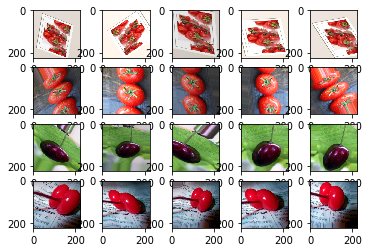

In [13]:
_, axes = plt.subplots(4, 5)

for image in range(axes.shape[0]):
    for example in tqdm(range(axes.shape[1])):
        axes[image,example].imshow(train_data_gen[0][0][image])

## [3] Training

### 3.1 Create a transfer learning model

In [14]:
train_histories = []

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False # freeze the pre-trained bit

# wrap the model in a sequential model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.AveragePooling2D(),
    Flatten(),
    Dropout(0.25),
    Dense(3, activation='softmax'),
])

9412608/9406464 [==============================] - 2s 0us/step


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
average_pooling2d (AveragePo (None, 3, 3, 1280)        0         
_________________________________________________________________
flatten (Flatten)            (None, 11520)             0         
_________________________________________________________________
dropout (Dropout)            (None, 11520)             0         
_________________________________________________________________
dense (Dense)                (None, 3)                 34563     
Total params: 2,292,547
Trainable params: 34,563
Non-trainable params: 2,257,984
_________________________________________________________________


### 3.2 Train the trail of the model

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

r = model.fit_generator(
    train_data_gen,
    validation_data=test_data_gen,
    epochs=15,
)

train_histories.append(r.history)

### 3.3 Unfreeze some of the pre-trained model and continue training

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

r = model.fit_generator(
    train_data_gen,
    validation_data=test_data_gen,
    initial_epoch=15,
    epochs=30,
)

train_histories.append(r.history)

### 3.4 Unfreeze more of the pre-trained model and continue training

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:50]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(lr=3e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

r = model.fit_generator(
    train_data_gen,
    validation_data=test_data_gen,
    initial_epoch=30,
    epochs=40,
)

train_histories.append(r.history)

### 3.5 Save the model

In [ ]:
make_dir('models')

model_id = str(uuid.uuid4()).split('-')[0]
model.save(f'models/{model_id}.h5')

### 3.6 Visualise the training history

In [ ]:
ANY_SERIES = list(train_histories[0].keys())[0] # arbitrary key

fig, (ax_accuracy, ax_loss) = plt.subplots(2, 1)

n_epochs = sum(len(history[ANY_SERIES]) for history in train_histories)
epochs = np.arange(1, n_epochs + 1)

series = defaultdict(list)
phase_boundaries = [1]
for history in train_histories:
    for series_name, values in history.items():
        series[series_name] += values
    phase_boundaries += [len(series[ANY_SERIES])]
        
for phase_boundary in phase_boundaries:
    for ax in [ax_accuracy, ax_loss]:
        ax.axvline(
            phase_boundary,
            color='black',
            linestyle='--'
        )
        
ax_accuracy.set_title('Accuracy')
ax_accuracy.plot(epochs, series['accuracy'], label='accuracy')
ax_accuracy.plot(epochs, series['val_accuracy'], label='val accuracy')
ax_accuracy.legend()

ax_loss.set_title('Loss')
ax_loss.plot(epochs, series['loss'], label='loss')
ax_loss.plot(epochs, series['val_loss'], label='val loss')
ax_loss.legend()

plt.savefig(f'models/{model_id}.png', dpi=300)

### 3.7 Draw a ternary plot of the model's predictions

In [215]:
def plot_ternary(labels, y_true, y_pred):
    _, axes = plt.subplots(1, len(labels), figsize=(12, 3.5))
    
    for label, ax in zip(labels, axes):
        figure, tax = ternary.figure(ax=ax)

        # Draw Boundary and Gridlines
        tax.gridlines(color="black", multiple=0.1)
        tax.gridlines(color="blue", multiple=1, linewidth=0.5)

        # Set Axis labels and Title
        tax.set_title(label)
        tax.left_axis_label(labels[0])
        tax.right_axis_label(labels[1])
        tax.bottom_axis_label(labels[2])

        tax.ticks(axis='lbr', linewidth=1)

        # Remove default Matplotlib Axes
        tax.clear_matplotlib_ticks()
        
        for instance_class, instance_pred in zip(y_true, y_pred):
            if instance_class == label:
                color = ['r', 'g', 'b'][np.argmax(instance_pred)]
                tax.scatter([instance_pred], color=color, s=5)
        

#adapted from: https://stackoverflow.com/questions/2148543/how-to-write-a-confusion-matrix-in-python
def plot_confusion_matrix(labels, confusion):
    _, ax = plt.subplots(1)
    plt.imshow(confusion, cmap=plt.cm.Blues, vmin=0, aspect='equal') # imshow
    plt.colorbar()
    
    tick_marks = np.arange(len(labels))
    
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    plt.ylabel('Actual')
    plt.xlabel('Predicted')

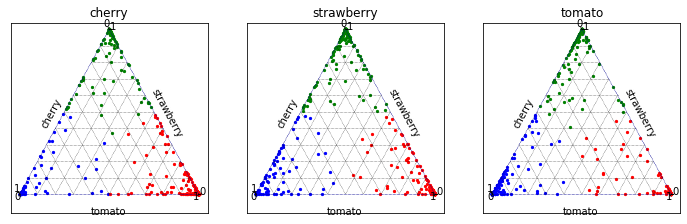

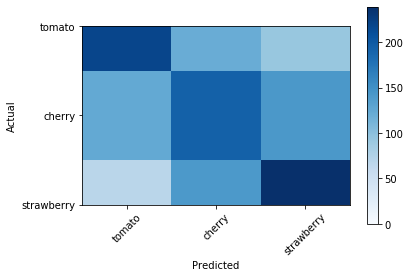

In [216]:
plot_ternary(
    model.classes_,
    y_test,
    model.predict_proba(X_test),
)

plt.show()

plot_confusion_matrix(
    labels,
    sklearn.metrics.confusion_matrix(
        y_test,
        model.predict(X_test)
    )
)